# Assignment 4- b: Meta learning

b) Write a colab for very simple and easy meta learning task

**Meta Learning: Omniglot Few-Shot Classification**

Reference: 
1. A repo containing lots of few-shot learning models: https://github.com/oscarknagg/few-shot
2. A pytorch implementation: https://github.com/dragen1860/MAML-Pytorch
3. The official Tf implementation: https://github.com/cbfinn/maml
4. Omniglot dataset: https://github.com/brendenlake/omniglot
5. https://colab.research.google.com/drive/1OcF5TQCCd7WNK0cbXyzYxAzWpMKW_r8B
6. https://drive.google.com/open?id=1DjwXTpEVK__f5dmlkU4kUgaaTmFtHfIw

7. https://drive.google.com/open?id=1FUVULNb8LwTt8Ixs3vra6poGeRcOap4n

# **Step 1: Download dataset**

First, we have to download Omniglot dataset.




In [7]:
workspace_dir = '.'
!gdown --id 1FLDrQ0k-iJ-mk8ors0WItqvwgu0w9J0U --output "{workspace_dir}/Omniglot.tar.gz"

Downloading...
From: https://drive.google.com/uc?id=1FLDrQ0k-iJ-mk8ors0WItqvwgu0w9J0U
To: /content/Omniglot.tar.gz
26.4MB [00:00, 162MB/s] 


In [8]:
!tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"  

In [9]:
from PIL import Image
from IPython.display import display
import numpy as np

In [10]:

for i in range(10, 20):
  im = Image.open("Omniglot/images_background/Japanese_(hiragana).0/character13/0500_" + str (i) + ".png")
  display(im)

# **Step 2: Creating a model**

Below we will start to build the core MAML model
First we will introduce the required kit

In [4]:
# Import modules we need
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import glob
from tqdm import tqdm
import numpy as np
from collections import OrderedDict

In [5]:
def ConvBlock(in_ch, out_ch):
  return nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding = 1),
                       nn.BatchNorm2d(out_ch),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size = 2, stride = 2)) #  strided convolution
                                                                  #  max pool (mini imagenet)
                                                                  
def ConvBlockFunction(x, w, b, w_bn, b_bn):
  x = F.conv2d(x, w, b, padding = 1)
  x = F.batch_norm(x, running_mean = None, running_var = None, weight = w_bn, bias = b_bn, training = True)
  x = F.relu(x)
  x = F.max_pool2d(x, kernel_size = 2, stride = 2)
  return x

class Classifier(nn.Module):
  def __init__(self, in_ch, k_way):
    super(Classifier, self).__init__()
    self.conv1 = ConvBlock(in_ch, 64)
    self.conv2 = ConvBlock(64, 64)
    self.conv3 = ConvBlock(64, 64)
    self.conv4 = ConvBlock(64, 64)
    self.logits = nn.Linear(64, k_way)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.logits(x)
    return x

  def functional_forward(self, x, params):
    '''
    Arguments:
    x: input images [batch, 1, 28, 28]
    params:  convolution : weight & bias， batchnormalization:  weight & bias
    '''
    for block in [1, 2, 3, 4]:
      x = ConvBlockFunction(x, params[f'conv{block}.0.weight'], params[f'conv{block}.0.bias'],
                            params.get(f'conv{block}.1.weight'), params.get(f'conv{block}.1.bias'))
    x = x.view(x.shape[0], -1)
    x = F.linear(x, params['logits.weight'] , params['logits.bias'])
    return x


In [6]:
def create_label(n_way, k_shot):
  return torch.arange(n_way).repeat_interleave(k_shot).long()
  
# to generate a label for 5 way 2 shot.
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [7]:
def MAML(model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 1, inner_lr = 0.4, train = True):
  """
  Args:
  x is the input omniglot images for a meta_step, shape = [batch_size, n_way * (k_shot + q_query), 1, 28, 28]
  n_way
  k_shot
  q_query
  """
  criterion = loss_fn
  task_loss = [] 
  task_acc = []  s 
  for meta_batch in x:
    train_set = meta_batch[:n_way*k_shot] 
    val_set = meta_batch[n_way*k_shot:]   
    
    fast_weights = OrderedDict(model.named_parameters()) 
    
    for inner_step in range(inner_train_step): 
                                       
      train_label = create_label(n_way, k_shot).cuda()
      logits = model.functional_forward(train_set, fast_weights)
      loss = criterion(logits, train_label)
      grads = torch.autograd.grad(loss, fast_weights.values(), create_graph = True)     
      fast_weights = OrderedDict((name, param - inner_lr * grad)
                                  for ((name, param), grad) in zip(fast_weights.items(), grads)) 
  
    val_label = create_label(n_way, q_query).cuda()
    logits = model.functional_forward(val_set, fast_weights) 
    loss = criterion(logits, val_label)                      
    task_loss.append(loss)                                   
    acc = np.asarray([torch.argmax(logits, -1).cpu().numpy() == val_label.cpu().numpy()]).mean() #accuracy
    task_acc.append(acc)
    
  model.train()
  optimizer.zero_grad()
  meta_batch_loss = torch.stack(task_loss).mean() 
  if train:
    meta_batch_loss.backward()
    optimizer.step()
  task_acc = np.mean(task_acc)
  return meta_batch_loss, task_acc

In [8]:
class Omniglot(Dataset):
  def __init__(self, data_dir, k_way, q_query):
    self.file_list = [f for f in glob.glob(data_dir + "**/character*", recursive=True)]
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.n = k_way + q_query
  def __getitem__(self, idx):
    sample = np.arange(20)
    np.random.shuffle(sample) 
    img_path = self.file_list[idx]
    img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
    img_list.sort()
    imgs = [self.transform(Image.open(img_file)) for img_file in img_list]
    imgs = torch.stack(imgs)[sample[:self.n]] 
    return imgs
  def __len__(self):
    return len(self.file_list)    

# **Step 3: Start training**

Defining hyperparameters 

In [9]:
n_way = 5
k_shot = 1
q_query = 1
inner_train_step = 1
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 40
eval_batches = test_batches = 20
train_data_path = './Omniglot/images_background/'
test_data_path = './Omniglot/images_evaluation/'

Initializing dataloader:

In [11]:
#dataset = Omniglot(train_data_path, k_shot, q_query)
train_set, val_set = torch.utils.data.random_split(Omniglot(train_data_path, k_shot, q_query), [3200,656])
train_loader = DataLoader(train_set,
                          batch_size = n_way, 
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
val_loader = DataLoader(val_set,
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
test_loader = DataLoader(Omniglot(test_data_path, k_shot, q_query),
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
train_iter = iter(train_loader)
val_iter = iter(val_loader)
test_iter = iter(test_loader)

Initializing model and optimizer

In [12]:
meta_model = Classifier(1, n_way).cuda()
optimizer = torch.optim.Adam(meta_model.parameters(), lr = meta_lr)
loss_fn = nn.CrossEntropyLoss().cuda()

The function to capture a meta-batch data

In [13]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
  data = []
  for _ in range(meta_batch_size):
    try:
      task_data = iterator.next()  
    except StopIteration:
      iterator = iter(data_loader)
      task_data = iterator.next()
    train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
    val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
    task_data = torch.cat((train_data, val_data), 0)
    data.append(task_data)
  return torch.stack(data).cuda(), iterator

Start training

In [14]:
for epoch in range(max_epoch):
  print("Epoch %d" %(epoch))
  train_meta_loss = []
  train_acc = []
  for step in tqdm(range(len(train_loader) // (meta_batch_size))): 
    x, train_iter = get_meta_batch(meta_batch_size, k_shot, q_query, train_loader, train_iter)
    meta_loss, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn)
    train_meta_loss.append(meta_loss.item())
    train_acc.append(acc)
  print("  Loss    : ", np.mean(train_meta_loss))
  print("  Accuracy: ", np.mean(train_acc))


  val_acc = []
  for eval_step in tqdm(range(len(val_loader) // (eval_batches))):
    x, val_iter = get_meta_batch(eval_batches, k_shot, q_query, val_loader, val_iter)
    _, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 3, train = False) # testing時，我們更新三次 inner-step
    val_acc.append(acc)
  print("  Validation accuracy: ", np.mean(val_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  1.6269280016422272
  Accuracy:  0.43187500000000006


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.43166666666666664
Epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  1.1513133883476256
  Accuracy:  0.5728125000000002


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.49166666666666664
Epoch 2


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  1.008468559384346
  Accuracy:  0.6318749999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.5783333333333335
Epoch 3


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.8547901004552841
  Accuracy:  0.7096875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.6016666666666667
Epoch 4


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.6845514297485351
  Accuracy:  0.77125


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7100000000000001
Epoch 5


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.5771005377173424
  Accuracy:  0.8134375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7866666666666667
Epoch 6


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.5235501289367676
  Accuracy:  0.8225


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7666666666666667
Epoch 7


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.4569124221801758
  Accuracy:  0.8590625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8366666666666668
Epoch 8


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.4227875232696533
  Accuracy:  0.866875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8583333333333334
Epoch 9


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.3877933233976364
  Accuracy:  0.874375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9
Epoch 10


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.34943031668663027
  Accuracy:  0.8949999999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9083333333333333
Epoch 11


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.32028337717056277
  Accuracy:  0.9028125000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.92
Epoch 12


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.28799888119101524
  Accuracy:  0.915625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9033333333333333
Epoch 13


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.279572618752718
  Accuracy:  0.9181250000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9166666666666669
Epoch 14


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2614533990621567
  Accuracy:  0.9228125


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9433333333333332
Epoch 15


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.23661379143595695
  Accuracy:  0.9271874999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9383333333333335
Epoch 16


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.23275572061538696
  Accuracy:  0.9331249999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9366666666666669
Epoch 17


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.22926411181688308
  Accuracy:  0.934375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.93
Epoch 18


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.20309944525361062
  Accuracy:  0.945625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.94
Epoch 19


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.20841981694102288
  Accuracy:  0.9396875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9533333333333333
Epoch 20


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.20849145874381064
  Accuracy:  0.9356249999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9466666666666667
Epoch 21


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1898741155862808
  Accuracy:  0.9425000000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9433333333333335
Epoch 22


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.19950357601046562
  Accuracy:  0.9399999999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9566666666666667
Epoch 23


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.17395180463790894
  Accuracy:  0.9509375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9633333333333334
Epoch 24


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1837262149900198
  Accuracy:  0.9453125000000002


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9666666666666668
Epoch 25


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1732922699302435
  Accuracy:  0.9493750000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9416666666666665
Epoch 26


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.16669684946537017
  Accuracy:  0.9534375000000003


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9666666666666667
Epoch 27


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1467659328132868
  Accuracy:  0.9603124999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9683333333333333
Epoch 28


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1636076107621193
  Accuracy:  0.9515625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9500000000000001
Epoch 29


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.15533218160271645
  Accuracy:  0.9553125000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9583333333333334
Epoch 30


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14764776676893235
  Accuracy:  0.9546875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9633333333333334
Epoch 31


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14620956256985665
  Accuracy:  0.954375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.965
Epoch 32


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14870485588908194
  Accuracy:  0.9528125000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9616666666666668
Epoch 33


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1474894244223833
  Accuracy:  0.9512499999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9683333333333333
Epoch 34


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14505538232624532
  Accuracy:  0.9556250000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.955
Epoch 35


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13165343701839446
  Accuracy:  0.961875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9616666666666666
Epoch 36


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.12260847203433514
  Accuracy:  0.9643750000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.96
Epoch 37


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.12339781932532787
  Accuracy:  0.9650000000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.965
Epoch 38


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1188812404870987
  Accuracy:  0.9628125000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9516666666666668
Epoch 39


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13708176650106907
  Accuracy:  0.9603125


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

  Validation accuracy:  0.9716666666666668


In [15]:
test_acc = []
for test_step in tqdm(range(len(test_loader) // (test_batches))):
  x, test_iter = get_meta_batch(test_batches, k_shot, q_query, test_loader, test_iter)
  _, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 3, train = False) # testing 時，我們更新三次 inner-step
  test_acc.append(acc)
print("  Testing accuracy: ", np.mean(test_acc))

100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

  Testing accuracy:  0.9383333333333334


The testing accuracy is almost 94%

# **Another example for Few-Shot learning with Reptile**
Reference: https://keras.io/examples/vision/reptile/

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Define the Hyperparameters

In [22]:
#Define the Hyperparameters
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

Prepare the data

In [23]:
#Prepare the data
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
            self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Visualize some examples from the dataset

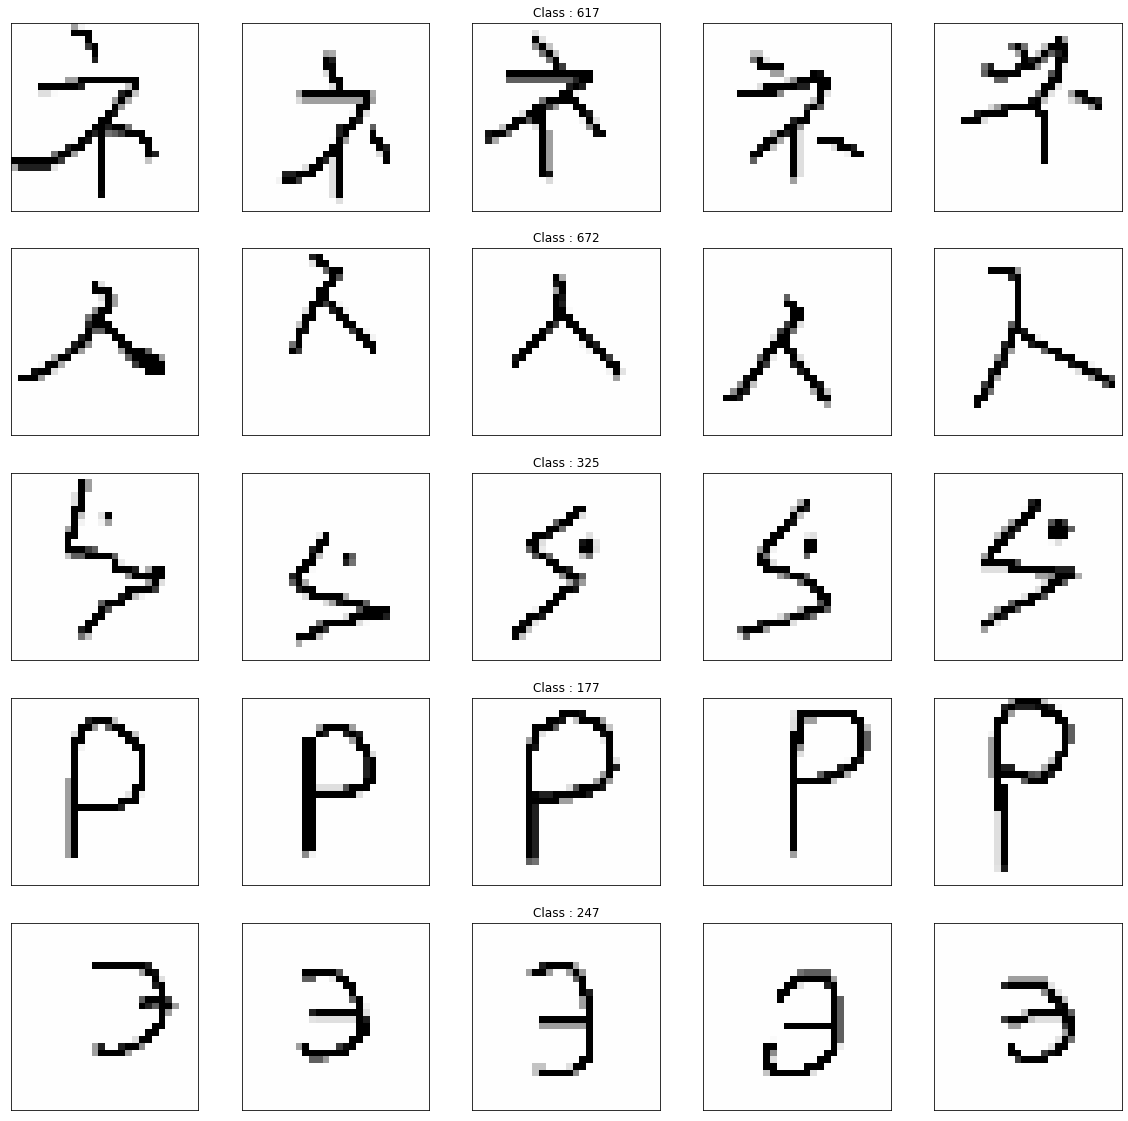

In [24]:
#Visualize some examples from the dataset
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

Build the model

In [26]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


Train the model


In [27]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.400000 test=0.200000
batch 100: train=0.800000 test=0.600000
batch 200: train=1.000000 test=1.000000
batch 300: train=0.600000 test=1.000000
batch 400: train=0.800000 test=0.600000
batch 500: train=1.000000 test=0.800000
batch 600: train=1.000000 test=1.000000
batch 700: train=1.000000 test=1.000000
batch 800: train=1.000000 test=1.000000
batch 900: train=1.000000 test=1.000000
batch 1000: train=1.000000 test=1.000000
batch 1100: train=0.800000 test=0.600000
batch 1200: train=0.800000 test=1.000000
batch 1300: train=1.000000 test=0.600000
batch 1400: train=1.000000 test=1.000000
batch 1500: train=0.800000 test=1.000000
batch 1600: train=0.800000 test=1.000000
batch 1700: train=1.000000 test=1.000000
batch 1800: train=0.800000 test=1.000000
batch 1900: train=0.400000 test=0.800000


Visualize Results

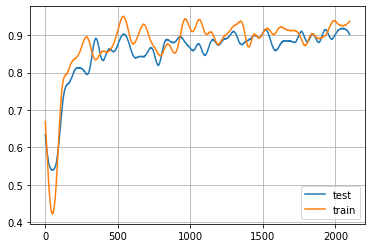

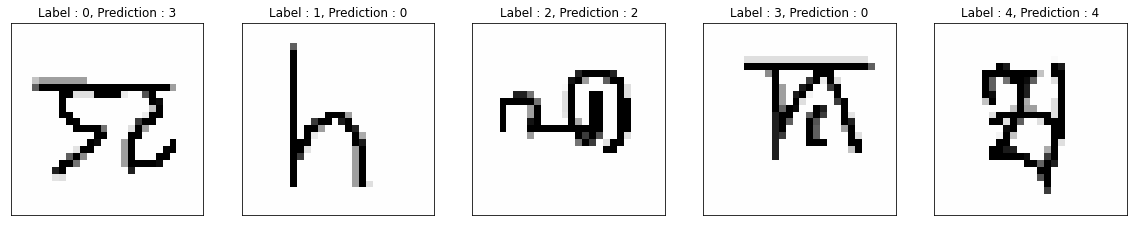

In [28]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()